# Looking at the randomness (or otherwise) of mouse behaviour
### Also, the randomness (or otherwise) of trial types to know when best to start looking at 'full task' behaviour

In [1]:
# Import libraries
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns 
import random
import copy
import numpy as np
from scipy.signal import resample
from scipy.stats import zscore
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import cross_validation

In [2]:
# Load data
# data loading function
def data_load_and_parse(mouse_name):
    tt = pd.read_csv('~/work/whiskfree/data/trialtype_' + mouse_name + '.csv',header=None)
    ch = pd.read_csv('~/work/whiskfree/data/choice_' + mouse_name + '.csv',header=None)
    sess = pd.read_csv('~/work/whiskfree/data/session_' + mouse_name + '.csv',header=None)
    AB = pd.read_csv('~/work/whiskfree/data/AB_' + mouse_name + '.csv',header=None)
    
    clean1 = np.nan_to_num(tt) !=0
    clean2 = np.nan_to_num(ch) !=0
    clean = clean1&clean2
    tt_c = tt[clean].values

    ch_c = ch[clean].values
    
    s_c = sess[clean].values
    
    ab_c = AB[clean].values
    
    return tt_c, ch_c, clean, s_c, ab_c

In [3]:
mouse_name = '36_r'
tt, ch, clean, sess, AB = data_load_and_parse(mouse_name)


# work out AB/ON trials
AB_pol = np.nan_to_num(AB) !=0
ON_pol = np.nan_to_num(AB) ==0
cm_AB = confusion_matrix(tt[AB_pol],ch[AB_pol])
cm_ON = confusion_matrix(tt[ON_pol],ch[ON_pol])
print(cm_AB)
print(cm_ON)
print(accuracy_score(tt[AB_pol],ch[AB_pol]))
print(accuracy_score(tt[ON_pol],ch[ON_pol]))

[[293  42  47]
 [ 63 213  42]
 [ 85  25 220]]
[[180  23  28]
 [ 41 139  26]
 [ 52  47 198]]
0.704854368932
0.704359673025


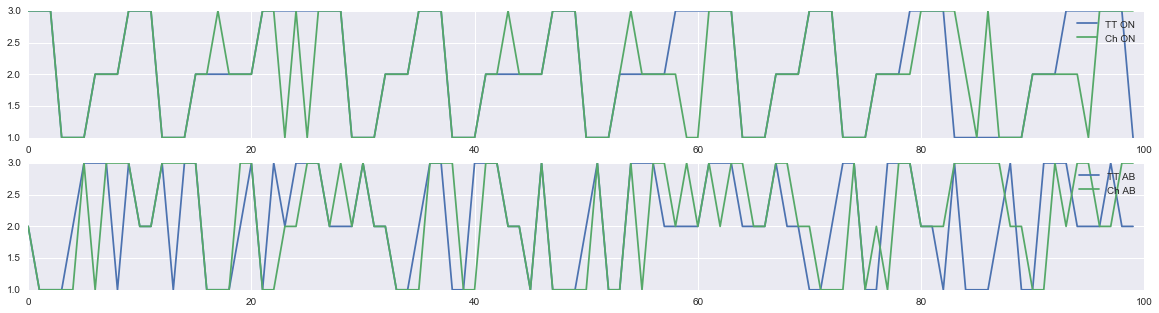

In [4]:
# Format TT/ choice data and plot
fig, ax = plt.subplots(2,1,figsize=(20,5))
_ = ax[0].plot(tt[ON_pol][:100],label='TT ON')
_ = ax[0].plot(ch[ON_pol][:100],label='Ch ON')
ax[0].legend()
_ = ax[1].plot(tt[AB_pol][:100],label='TT AB')
_ = ax[1].plot(ch[AB_pol][:100],label='Ch AB')
ax[1].legend()

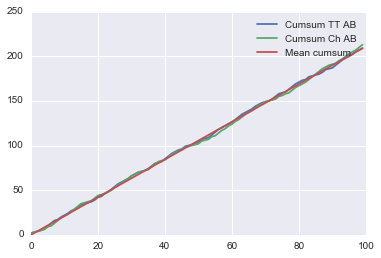

In [5]:
# Measure randomness and plot that
# First plot cumsum of trial types. Periods of bias (of choice 1 and 3, anyway) will be seen as deviations from the mean line
plt.plot(np.cumsum(tt[AB_pol][:100]),label='Cumsum TT AB')
plt.plot(np.cumsum(ch[AB_pol][:100]),label='Cumsum Ch AB')
plt.plot([0,99],[0,np.sum(tt[AB_pol][:100])],label='Mean cumsum')
plt.legend()

/Users/mathew/miniconda/envs/graph_tool/lib/python3.4/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2050 but corresponding boolean dimension is 1261
/Users/mathew/miniconda/envs/graph_tool/lib/python3.4/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2050 but corresponding boolean dimension is 1261
/Users/mathew/miniconda/envs/graph_tool/lib/python3.4/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2050 but corresponding boolean dimension is 1261


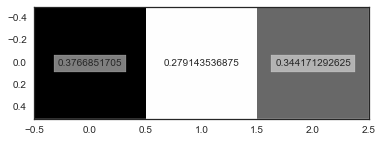

In [6]:
# How about looking at the distribution of individual states, pairs, triples. 
# Compare to random sequence (with no conditions)
P_i = np.zeros(3)
P_i[0] = len(tt[tt[AB_pol]==1])
P_i[1] = len(tt[tt[AB_pol]==2])
P_i[2] = len(tt[tt[AB_pol]==3])
with sns.axes_style("white"):
    _ = plt.imshow(np.expand_dims(P_i/sum(P_i),axis=0),interpolation='none')
    for j in range(0,3):
        plt.text(j, 0, P_i[j]/sum(P_i), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

#     _ = ax[1].bar([0,1,2],P_i/sum(P_i))



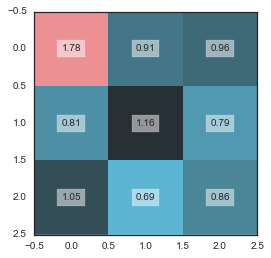

In [7]:
# Pairs and triples (in dumb O(n) format)
P_ij = np.zeros([3,3])
P_ijk = np.zeros([3,3,3])
for i in range(len(tt[AB_pol]) - 2):
    #p_i = tt[AB_pol][i]
    #p_j = tt[AB_pol][i+1]
    #p_k = tt[AB_pol][i+2]
    p_i = ch[AB_pol][i]
    p_j = ch[AB_pol][i+1]
    p_k = ch[AB_pol][i+2]
    P_ij[p_i-1,p_j-1] += 1
    P_ijk[p_i-1,p_j-1,[p_k-1]] += 1
    
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black

with sns.axes_style("white"):
    plt.imshow(P_ij/np.sum(P_ij),interpolation='none',cmap=cmap)
    
for i in range(0,3):
    for j in range(0,3):
        plt.text(j, i, "{0:.2f}".format(P_ij[i,j]/np.sum(P_ij)*9), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

#plt.savefig('figs/graphs/state_transition_matrix_AB'+ mouse_name +'.png')
plt.savefig('figs/graphs/choice_state_transition_matrix_AB'+ mouse_name +'.png')

0.037037037037037035

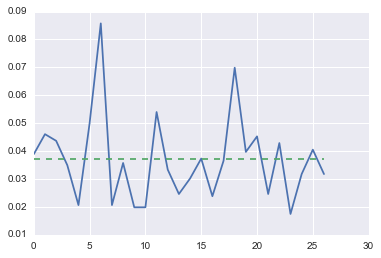

In [60]:
# Plot P(state) for all 27 triple states
plt.plot(P_ijk_ON.flatten()/np.sum(P_ijk_ON))
plt.plot([0,26],[1/27,1/27],'--')
1/27

In [17]:
import graph_tool.all as gt


/Users/mathew/miniconda/envs/graph_tool/lib/python3.4/site-packages/graph_tool/draw/cairo_draw.py:1468: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


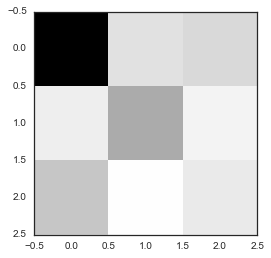

In [10]:
# Transition probabilities between individual states, pairs, triples
g = gt.Graph()
g.add_edge_list(np.transpose(P_ij.nonzero()))
with sns.axes_style("white"):
	plt.imshow(P_ij,interpolation='none')

In [11]:
g = gt.Graph(directed = True)
g.add_vertex(len(P_ij))
edge_weights = g.new_edge_property('double')
edge_labels = g.new_edge_property('string')
for i in range(P_ij.shape[0]):
  for j in range(P_ij.shape[1]):
    e = g.add_edge(i, j)
    edge_weights[e] = P_ij[i,j]
    edge_labels[e] = str(P_ij[i,j])
    

[60 60 60]


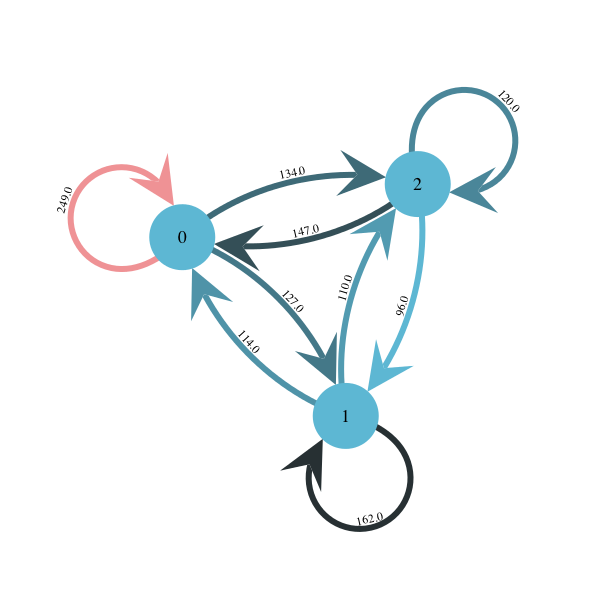

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x126580cc0, at 0x114df7470>

In [12]:
# Fancy drawing code where node colour/size is degree. Edge colour/size is betweenness
deg = g.degree_property_map("in")
# deg.a = 4 * (np.sqrt(deg.a) * 0.5 + 0.4)
deg.a = deg.a*20
print(deg.a)
ewidth = edge_weights.a / 10
#ebet.a /= ebet.a.max() / 10.
#print(ebet.a)
pos = gt.sfdp_layout(g)
#control = g.new_edge_property("vector<double>")
#for e in g.edges():
#  d = np.sqrt(sum((pos[e.source()].a - pos[e.target()].a) ** 2))
#  print(d)
#  control[e] = [10, d, 10,d] #[0.3, d, 0.7, d]
  
  

cmap = sns.cubehelix_palette(as_cmap=True)  # cubehelix 
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black
# gt.graph_draw(g, pos=pos, vertex_size=deg, vertex_fill_color=deg, vorder=deg,
#              edge_color=ebet, eorder=eorder, edge_pen_width=ebet,
#              edge_control_points=control) # some curvy edges
              # output="graph-draw.pdf")
gt.graph_draw(g, pos=pos, vertex_size=deg, vertex_color=deg, vertex_fill_color=deg,  edge_color=edge_weights, edge_text=edge_labels,
              vcmap=cmap,ecmap=cmap, vertex_text=g.vertex_index, vertex_font_size=18,fit_view=0.5)
              #vcmap=plt.cm.Pastel1,ecmap=plt.cm.Pastel1 )
       #       edge_control_points=control) # some curvy edges
              # output="graph-draw.pdf")

In [13]:
# Same as g but normalised so total trials/9 = 1
g_n = gt.Graph(directed = True)

edge_weights_n = g_n.new_edge_property('double')
edge_labels_n = g_n.new_edge_property('string')
node_size_n = g_n.new_vertex_property('double')
g_n.add_vertex(len(P_ij))

P_ij_n = P_ij /(P_ij.sum()/9)
for i in range(P_ij.shape[0]):
    #v = g_n.add_vertex()
    node_size_n[i] = 3* sum(P_ij)[i] / np.sum(P_ij)
    for j in range(P_ij.shape[1]):
        e = g_n.add_edge(i, j)
        edge_weights_n[e] = P_ij_n[i,j]
        edge_labels_n[e] = "{0:.2f}".format(P_ij_n[i,j])

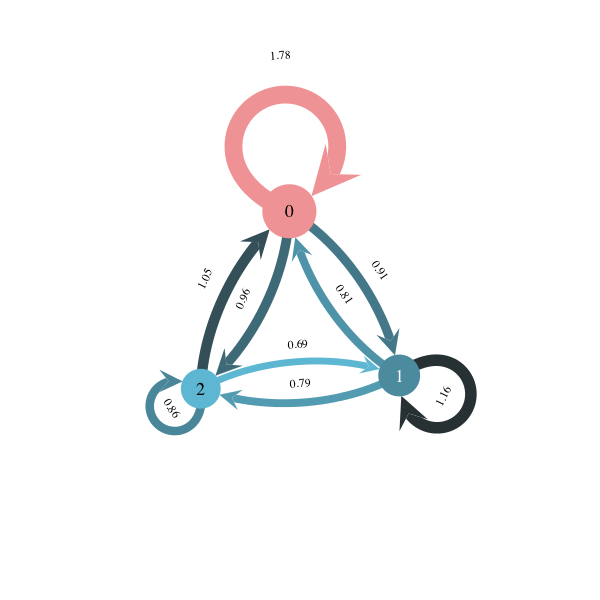

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x127147198, at 0x114df72b0>

In [14]:
# Minimal drawing code, but with scaled colours/weights for network properties
# Line width changes on each loop ATM. Needs fixing..
pos = gt.sfdp_layout(g_n)  

#deg_n = g_n.degree_property_map("in")
# deg.a = 4 * (np.sqrt(deg.a) * 0.5 + 0.4)
#deg_n.a = deg_n.a*20
n_size = copy.copy(node_size_n)
n_size.a = 50* n_size.a/ max(n_size.a)

edge_w = copy.copy(edge_weights_n)
edge_w.a = edge_w.a*10

cmap = sns.cubehelix_palette(as_cmap=True)  # cubehelix 
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black

gt.graph_draw(g_n, pos=pos, vertex_color = n_size, vertex_fill_color = n_size, 
              vertex_size = n_size,
              edge_pen_width=edge_w, edge_color=edge_weights_n, 
              edge_text=edge_labels_n,
              vcmap=cmap,ecmap=cmap, 
              vertex_text=g_n.vertex_index, 
              vertex_font_size=18,
              output_size=(600,600), fit_view=0.4,
              output="figs/graphs/choice_1st_order_transition_AB.pdf")
              #vcmap=plt.cm.Pastel1,ecmap=plt.cm.Pastel1 )
       #       edge_control_points=control) # some curvy edges
              # output="graph-draw.pdf")

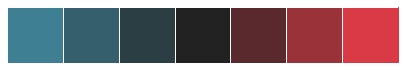

In [15]:
current_palette = sns.color_palette("cubehelix")
current_palette = sns.diverging_palette(220,10, l=50, n=7, center="dark")
sns.palplot(current_palette)



In [16]:
#  Now write a loop to construct a tree-type graph
# Same as g but normalised so total trials/9 = 1
t = gt.Graph(directed = False)

P_ij_n = P_ij /(P_ij.sum()/9)
P_ijk_n = P_ijk /(P_ijk.sum()/27)

edge_weights_t = t.new_edge_property('double')
edge_labels_t = t.new_edge_property('string')
node_labels_t = t.new_vertex_property('string')
node_size = t.new_vertex_property('double')
h = t.add_vertex()
node_labels_t[h] = "0"

for i in range(P_ij.shape[0]):
  v = t.add_vertex()
  node_labels_t[v] = str(i)
  e = t.add_edge(h,v)
  node_size[v] = sum(P_ij_n)[i] *10
  
  for j in range(P_ij.shape[1]):
    v2 = t.add_vertex()
    node_labels_t[v2] = str(i) + "-" + str(j)
    e = t.add_edge(v,v2)
    
    edge_weights_t[e] = P_ij_n[i,j]*10
    edge_labels_t[e] = "{0:.2f}".format(P_ij_n[i,j])
    node_size[v2] = P_ij_n[i,j]*20
    
    for k in range(P_ijk.shape[2]):
        v3 = t.add_vertex()
        node_labels_t[v3] = str(i) + "-" + str(j) + "-" + str(k)
        e2 = t.add_edge(v2,v3)
      
        edge_weights_t[e2] = P_ijk_n[i,j,k]*10
        edge_labels_t[e2] = "{0:.2f}".format(P_ijk_n[i,j,k])
        node_size[v3] = P_ijk_n[i,j,k]*20


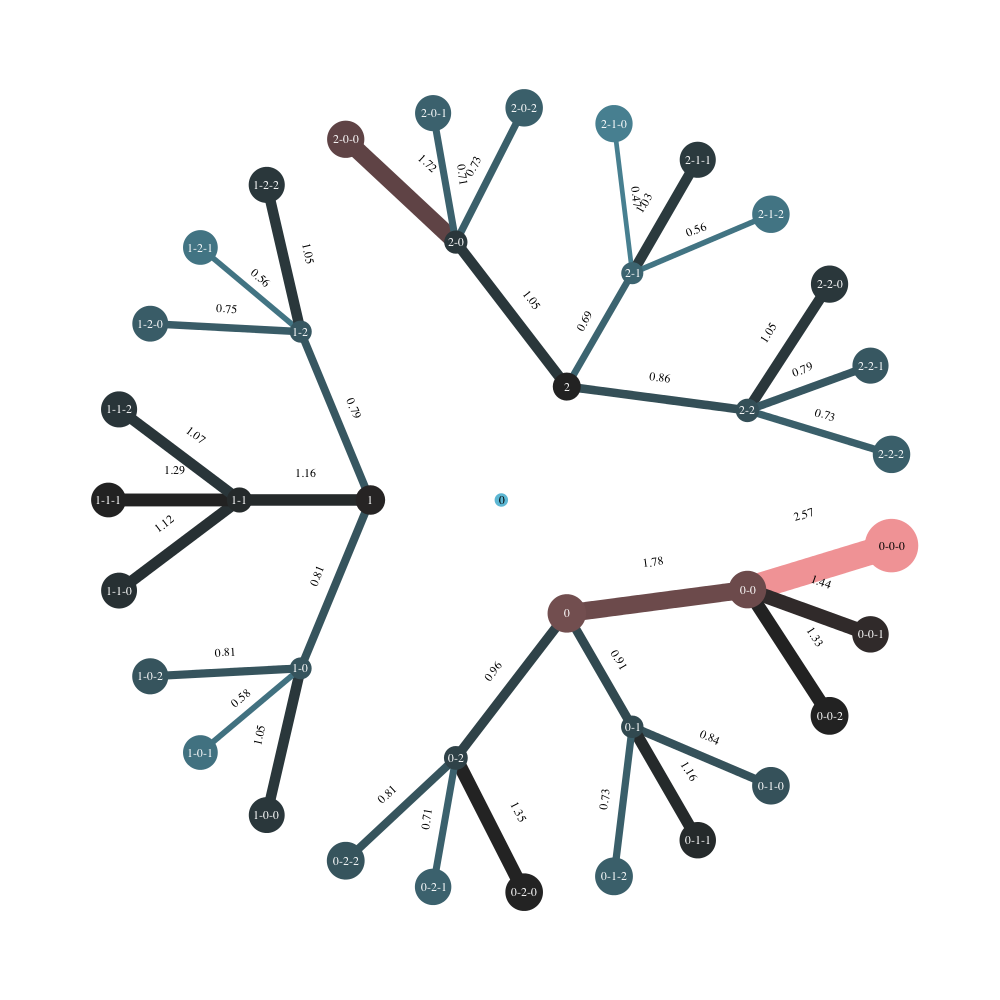

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12a0c4128, at 0x127186240>

In [17]:
#pos = gt.sfdp_layout(t) 
#pos = gt.fruchterman_reingold_layout(t)
pos = gt.radial_tree_layout(t,t.vertex(0))
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black

gt.graph_draw(t,pos=pos,vertex_size=node_size,edge_pen_width=edge_weights_t,
              vertex_text = node_labels_t, edge_text=edge_labels_t,
              ecmap=cmap, edge_color = edge_weights_t,
              vcmap=cmap, vertex_color = node_size,vertex_fill_color = node_size,
              output_size=(1000, 1000), fit_view=0.8,
              output="figs/graphs/choice_3_step_statespace_AB.pdf")

In [18]:
"{0:.2f}".format(P_ijk[1,1,1])

'60.00'

In [19]:
"{0:.2f}".format(P_ijk[1,1,1])

'60.00'

In [20]:
len(P_ij)

3

# Repeat the trick for ON policy trials

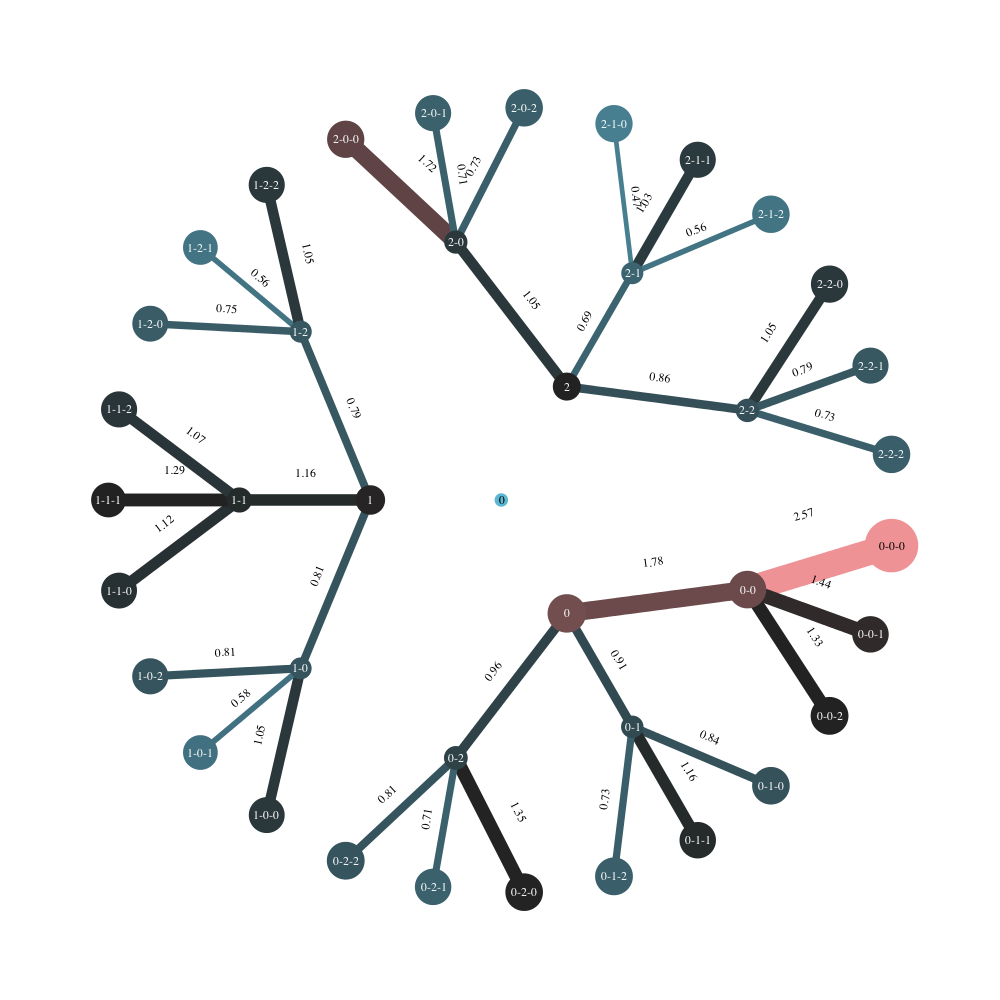

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1313b1588, at 0x1310bb908>

In [114]:
# P_ijk_ON
P_ij_ON = np.zeros([3,3])
P_ijk_ON = np.zeros([3,3,3])
for i in range(len(tt[AB_pol]) - 2):
#     p_i = tt[ON_pol][i]
#     p_j = tt[ON_pol][i+1]
#     p_k = tt[ON_pol][i+2]
    p_i = ch[AB_pol][i]
    p_j = ch[AB_pol][i+1]
    p_k = ch[AB_pol][i+2]
    P_ij_ON[p_i-1,p_j-1] += 1
    P_ijk_ON[p_i-1,p_j-1,[p_k-1]] += 1

# Make graph
t_ON = gt.Graph(directed = False)

P_ij_ON = P_ij_ON /(P_ij_ON.sum()/9)
P_ijk_ON = P_ijk_ON /(P_ijk_ON.sum()/27)

edge_weights_tON = t_ON.new_edge_property('double')
edge_labels_tON = t_ON.new_edge_property('string')
node_labels_tON = t_ON.new_vertex_property('string')
node_size_ON = t_ON.new_vertex_property('double')
h = t_ON.add_vertex()
node_labels_tON[h] = "0"

for i in range(P_ij_ON.shape[0]):
    v = t_ON.add_vertex()
    node_labels_tON[v] = str(i)
    e = t_ON.add_edge(h,v)
    node_size_ON[v] = sum(P_ij_ON)[i] *10
  
    for j in range(P_ij_ON.shape[1]):
        v2 = t_ON.add_vertex()
        node_labels_tON[v2] = str(i) + "-" + str(j)
        e = t_ON.add_edge(v,v2)
    
        edge_weights_tON[e] = P_ij_ON[i,j]*10
        edge_labels_tON[e] = "{0:.2f}".format(P_ij_ON[i,j])
        node_size_ON[v2] = P_ij_ON[i,j]*20
    
        for k in range(P_ijk_ON.shape[2]):
            v3 = t_ON.add_vertex()
            node_labels_tON[v3] = str(i) + "-" + str(j) + "-" + str(k)
            e2 = t_ON.add_edge(v2,v3)
      
            edge_weights_tON[e2] = P_ijk_ON[i,j,k]*10
            edge_labels_tON[e2] = "{0:.2f}".format(P_ijk_ON[i,j,k])
            node_size_ON[v3] = P_ijk_ON[i,j,k]*20

# Plot graph
pos = gt.radial_tree_layout(t_ON,t_ON.vertex(0))
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black

gt.graph_draw(t_ON,pos=pos,vertex_size=node_size_ON,edge_pen_width=edge_weights_tON,
              vertex_text = node_labels_tON, edge_text=edge_labels_tON,
              ecmap=cmap, edge_color = edge_weights_tON,
              vcmap=cmap, vertex_color = node_size_ON,
              vertex_fill_color = node_size_ON,
              output_size=(1000, 1000), fit_view=0.8)
#               output="figs/graphs/choice_3_step_statespace_AB_"+ mouse_name +".pdf")


([<matplotlib.axis.YTick at 0x12e7253c8>,
 <a list of 3 Text yticklabel objects>)

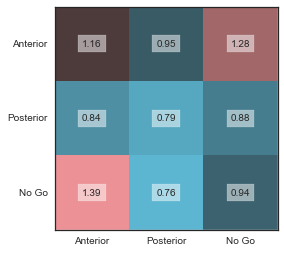

In [57]:
# image of ON trials transition matrix
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black

with sns.axes_style("white"):
    plt.imshow(P_ij_ON/np.sum(P_ij_ON),interpolation='none',cmap=cmap)
    
for i in range(0,3):
    for j in range(0,3):
        plt.text(j, i, "{0:.2f}".format(P_ij_ON[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

ylabels = ['Anterior','Posterior','No Go']
plt.xticks([0,1,2],ylabels)
plt.yticks([0,1,2],ylabels)
# plt.set_yticks([0,1,2])
# plt.set_yticklabels(ylabels)
        
# plt.savefig('figs/graphs/choice_state_transition_matrix_AB_'+ mouse_name +'.png')

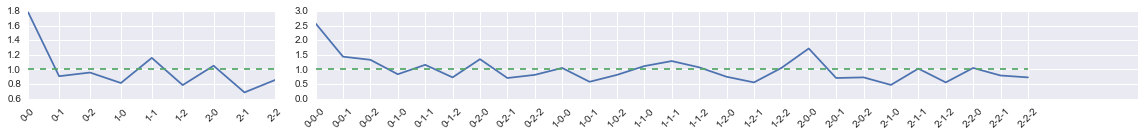

In [115]:
# Just plot P(state)
plt.figure(figsize=(16,2))
ax1 = plt.subplot2grid((1,4),(0,0))
ax1.plot(P_ij_ON.flatten()/np.sum(P_ij_ON) * 9)
ax1.plot([0,8],[1,1],'--')

state_names = np.empty([3,3],dtype=object)
for i in range(0,3):
    for j in range(0,3):
        state_names[i,j] = str(i) + "-" + str(j)
        
ax1.set_xticks(range(0,9))
ax1.set_xticklabels(state_names.flatten(),rotation=45)

ax2 = plt.subplot2grid((1,4),(0,1),colspan=3)
ax2.plot(P_ijk_ON.flatten()/np.sum(P_ijk_ON) * 27)
ax2.plot([0,26],[1,1],'--')

state_names = np.empty([3,3,3],dtype=object)
for i in range(0,3):
    for j in range(0,3):
        for k in range(0,3):
            state_names[i,j,k] = str(i) + "-" + str(j) + "-" + str(k)
        
_ = ax2.set_xticks(range(0,27))
_ = ax2.set_xticklabels(state_names.flatten(),rotation=45)

plt.tight_layout()

plt.savefig('figs/graphs/CH_state_prob_AB_'+ mouse_name +'.png')

In [4]:
from scipy.stats import chisquare
# chisquare(P_ij_ON.flatten())
chisquare?

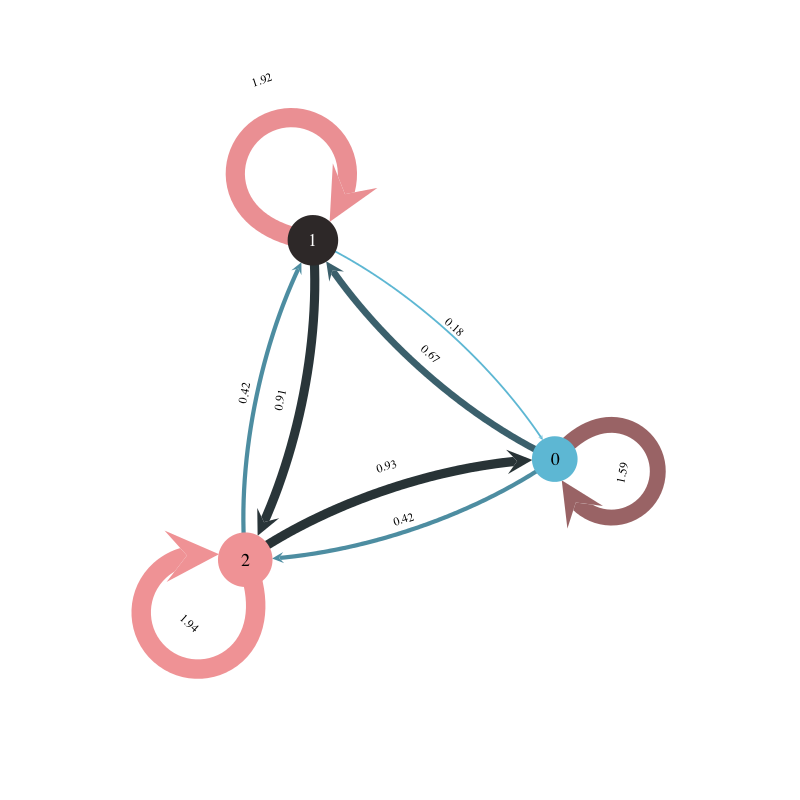

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12a64e5c0, at 0x12a22fa20>

In [23]:
# First order transition graph
g_ON = gt.Graph(directed = True)

edge_weights_ON = g_ON.new_edge_property('double')
edge_labels_ON = g_ON.new_edge_property('string')
node_size_ON = g_ON.new_vertex_property('double')
g_ON.add_vertex(len(P_ij_ON))

for i in range(P_ij_ON.shape[0]):
    #v = g_n.add_vertex()
    node_size_ON[i] = 3* sum(P_ij_ON)[i] / np.sum(P_ij_ON)
    for j in range(P_ij_ON.shape[1]):
        e = g_ON.add_edge(i, j)
        edge_weights_ON[e] = P_ij_ON[i,j]
        edge_labels_ON[e] = "{0:.2f}".format(P_ij_ON[i,j])
    
# Plot graph
pos = gt.sfdp_layout(g_ON)  
n_size = copy.copy(node_size_ON)
n_size.a = 50* n_size.a/ max(n_size.a)

edge_w = copy.copy(edge_weights_ON)
edge_w.a = edge_w.a*10

cmap = sns.cubehelix_palette(as_cmap=True)  # cubehelix 
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to red via black

gt.graph_draw(g_ON, pos=pos, vertex_color = n_size, vertex_fill_color = n_size, 
              vertex_size = n_size,
              edge_pen_width=edge_w, edge_color=edge_w, 
              edge_text=edge_labels_ON,
              vcmap=cmap,ecmap=cmap, 
              vertex_text=g_ON.vertex_index, 
              vertex_font_size=18,
              output_size=(800, 800), fit_view=0.45,
              output="figs/graphs/choice_1st_order_transition_ON"+ mouse_name +".pdf")


# Finally, transition probabilities for choices - do they follow the trial types?
## (Actually, let's just re-run the code from above changing tt to ch)

# Now, let's use graphs to visualise confusion matrices

In [5]:
cm_AB = confusion_matrix(tt[AB_pol],ch[AB_pol])
cm_ON = confusion_matrix(tt[ON_pol],ch[ON_pol])
print(cm_AB)
print(cm_ON)
print(accuracy_score(tt[AB_pol],ch[AB_pol]))
print(accuracy_score(tt[ON_pol],ch[ON_pol]))

[[401  32  42]
 [ 18 291  43]
 [ 91  63 280]]
[[199  14  27]
 [ 10 196  15]
 [ 27  54 247]]
0.770816812054
0.813688212928


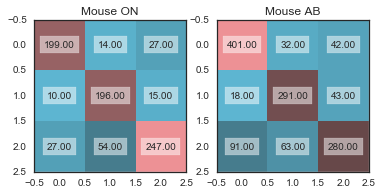

In [10]:
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to red via black
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(cm_ON/np.sum(cm_ON),interpolation='none',cmap=cmap)
    ax[1].imshow(cm_AB/np.sum(cm_AB),interpolation='none',cmap=cmap)
    
for i in range(0,3):
    for j in range(0,3):
        ax[0].text(j, i, "{0:.2f}".format(cm_ON[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))
        ax[1].text(j, i, "{0:.2f}".format(cm_AB[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

ax[0].set_title('Mouse ON')
ax[1].set_title('Mouse AB')
# plt.savefig('figs/graphs/confusion_matrix_AB_'+ mouse_name +'.png')

# Should also look at patterns in licking wrt correct/incorrect 

In [ ]:
for v in g.vertices():
    print(v)
for e in g.edges():
    print(e)

In [ ]:
19.19 - 9.92


In [ ]:
# gt.graph_draw(g,output_size=(400,400),fit_view=True,output='simple_graph.pdf')
gt.graph_draw(g2,output_size=(400,400),fit_view=True)

In [ ]:
deg.

In [ ]:
# Stats...

In [ ]:
len(tt[tt[AB_pol]])

In [26]:
gt.graph_draw?

## Load and plot protraction/retraction trial data for one mouse

In [4]:
# quick load and classification of pro/ret data
tt = pd.read_csv('~/work/whiskfree/data/tt_36_subset_sorted.csv',header=None)
ch = pd.read_csv('~/work/whiskfree/data/ch_36_subset_sorted.csv',header=None)
proret = pd.read_csv('~/work/whiskfree/data/proret_36_subset_sorted.csv',header=None)

tt = tt.values.reshape(-1,1)
ch = ch.values.reshape(-1,1)
proret = proret.values.reshape(-1,1)

In [5]:
cm = confusion_matrix(tt,ch)
print(cm)

[[231  41  37]
 [ 41 183  33]
 [ 75  18 172]]


[[198  28  83]
 [ 81 110  66]
 [  9 151 105]]
[[181  56 110]
 [ 60 131  51]
 [ 47 102  93]]


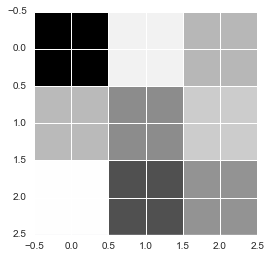

In [6]:
cm_tt_t = confusion_matrix(tt,proret)
cm_ch_t = confusion_matrix(ch,proret)

print(cm_tt_t)
print(cm_ch_t)
plt.imshow(cm_tt_t,interpolation='none')

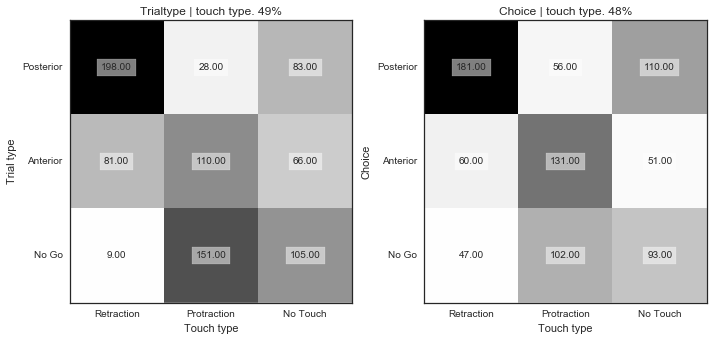

In [7]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,2,figsize=(10,6))
    ax[0].imshow(cm_tt_t/np.sum(cm_tt_t),interpolation='none')
    ax[1].imshow(cm_ch_t/np.sum(cm_ch_t),interpolation='none')
    
for i in range(0,3):
    for j in range(0,3):
        ax[0].text(j, i, "{0:.2f}".format(cm_tt_t[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))
        ax[1].text(j, i, "{0:.2f}".format(cm_ch_t[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

        
xlabels = ['Retraction','Protraction','No Touch']
ylabels = ['Posterior','Anterior','No Go']
ax[0].set_title('Trialtype | touch type' + '. ' + str(int(100 * accuracy_score(tt,proret))) + '%')
ax[1].set_title('Choice | touch type' + '. ' + str(int(100 * accuracy_score(ch,proret))) + '%')

ax[0].set_ylabel('Trial type')
ax[1].set_ylabel('Choice')
    
for i in range(0,2):
    ax[i].set_xlabel('Touch type')
    ax[i].set_xticks([0,1,2])
    ax[i].set_xticklabels(xlabels)
    ax[i].set_yticks([0,1,2])
    ax[i].set_yticklabels(ylabels)
    
plt.tight_layout()
    
# plt.savefig('../figs/classification/pro_ret/310816/touchtype_confmatrix_both_32.png')
plt.savefig('../figs/classification/pro_ret/36/touchtype_confmatrix_both_36.png')

In [13]:
lr_tt = LogisticRegression(solver='lbfgs',multi_class='multinomial')
lr_tt.fit(proret,tt)
c_tt = lr_tt.predict(proret)
print('TT prediction accuracy =',accuracy_score(tt,c_tt))
lr_ch = LogisticRegression(solver='lbfgs',multi_class='multinomial')
lr_ch.fit(proret,ch)
c_ch = lr_ch.predict(proret)
print('Choice prediction accuracy =',accuracy_score(ch,c_ch))
print('Mouse prediction accuracy =',accuracy_score(tt,ch))

TT prediction accuracy = 0.398315282792
Choice prediction accuracy = 0.397111913357
Mouse prediction accuracy = 0.705174488568


/Users/mathew/miniconda/envs/graph_tool/lib/python3.4/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mathew/miniconda/envs/graph_tool/lib/python3.4/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
print(confusion_matrix(ch,c_ch))
print(confusion_matrix(tt,c_tt))


[[237   0 110]
 [191   0  51]
 [149   0  93]]
[[226   0  83]
 [191   0  66]
 [160   0 105]]


In [10]:
print(accuracy_score(ch,proret))
print(accuracy_score(tt,proret))

0.487364620939
0.496991576414


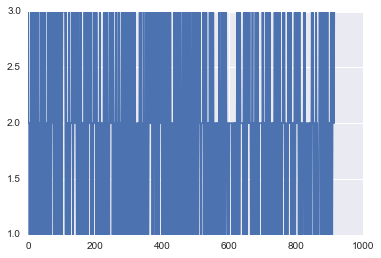

In [84]:
plt.plot(c_ch)

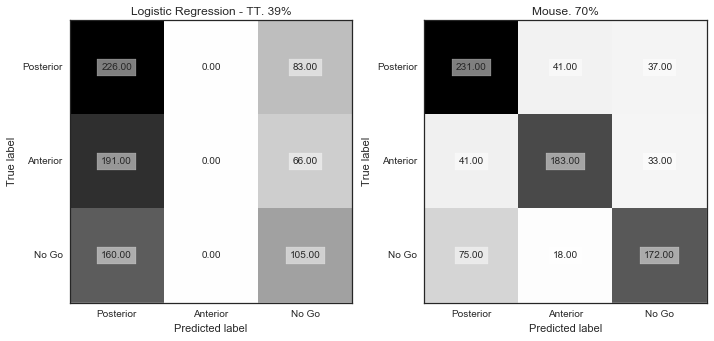

In [11]:
# Confusion matrix predicting trial type based on protraction/retraction
cm = confusion_matrix(tt,c_tt)
cm_m = confusion_matrix(tt,ch)

# xlabels = ['Retraction','Protraction','No Touch']
ylabels = ['Posterior','Anterior','No Go']
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,2,figsize=(10,6))
    ax[0].imshow(cm,interpolation='none')
    for i in range(0,3):
        for j in range(0,3):
            ax[0].text(j, i, "{0:.2f}".format(cm[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

        
    ax[0].set_title('Logistic Regression - TT' + '. ' + str(int(100 * accuracy_score(tt,c_tt))) + '%')

    ax[1].imshow(cm_m,interpolation='none')
    for i in range(0,3):
        for j in range(0,3):
            ax[1].text(j, i, "{0:.2f}".format(cm_m[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

    ax[1].set_title('Mouse' + '. ' + str(int(100 * accuracy_score(tt,ch))) + '%')

    for i in range(0,2):
        ax[i].set_ylabel('True label')
        ax[i].set_xlabel('Predicted label')
        ax[i].set_xticks([0,1,2])
        ax[i].set_xticklabels(ylabels)
        ax[i].set_yticks([0,1,2])
        ax[i].set_yticklabels(ylabels)
    
plt.tight_layout()

# plt.savefig('../figs/classification/pro_ret/310816/LR_confmatrix_TT_32.png')
plt.savefig('../figs/classification/pro_ret/36/LR_confmatrix_TT_36.png')

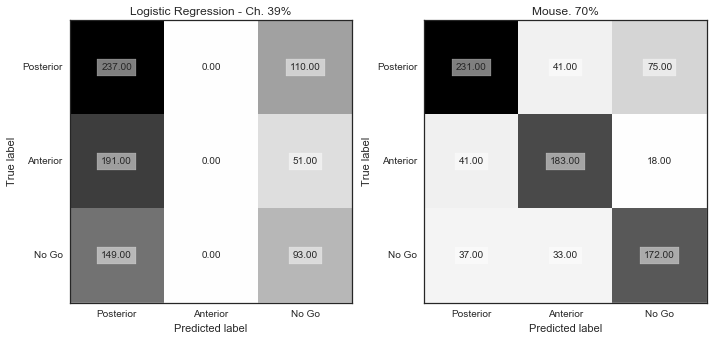

In [14]:
# Confusion matrix predicting choice based on protraction/retraction
cm_ch = confusion_matrix(ch,c_ch)
cm_m = confusion_matrix(ch,tt)

# xlabels = ['Retraction','Protraction','No Touch']
ylabels = ['Posterior','Anterior','No Go']
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,2,figsize=(10,6))
    ax[0].imshow(cm_ch,interpolation='none')
    for i in range(0,3):
        for j in range(0,3):
            ax[0].text(j, i, "{0:.2f}".format(cm_ch[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

        
    ax[0].set_title('Logistic Regression - Ch' + '. ' + str(int(100 * accuracy_score(ch,c_ch))) + '%')
    
    ax[1].imshow(cm_m,interpolation='none')
    for i in range(0,3):
        for j in range(0,3):
            ax[1].text(j, i, "{0:.2f}".format(cm_m[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

    ax[1].set_title('Mouse' + '. ' + str(int(100 * accuracy_score(ch,tt))) + '%')

    for i in range(0,2):
        ax[i].set_ylabel('True label')
        ax[i].set_xlabel('Predicted label')
        ax[i].set_xticks([0,1,2])
        ax[i].set_xticklabels(ylabels)
        ax[i].set_yticks([0,1,2])
        ax[i].set_yticklabels(ylabels)
    
plt.tight_layout()

# plt.savefig('../figs/classification/pro_ret/310816/LR_confmatrix_Ch_32.png')
plt.savefig('../figs/classification/pro_ret/36/LR_confmatrix_Ch_36.png')

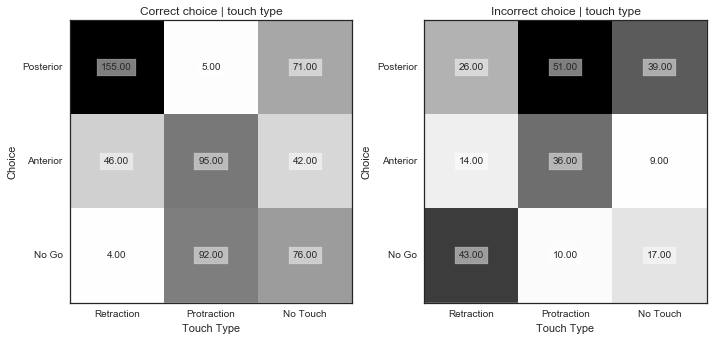

In [15]:
# Correct/incorrect
correct = tt==ch
errors = tt!=ch

cm_c = confusion_matrix(ch[correct],proret[correct])
cm_ic = confusion_matrix(ch[errors],proret[errors])

xlabels = ['Retraction','Protraction','No Touch']
ylabels = ['Posterior','Anterior','No Go']
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,2,figsize=(10,6))
    ax[0].imshow(cm_c,interpolation='none')
    for i in range(0,3):
        for j in range(0,3):
            ax[0].text(j, i, "{0:.2f}".format(cm_c[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

        
    ax[0].set_title('Correct choice | touch type')
    
    ax[1].imshow(cm_ic,interpolation='none')
    for i in range(0,3):
        for j in range(0,3):
            ax[1].text(j, i, "{0:.2f}".format(cm_ic[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

    ax[1].set_title('Incorrect choice | touch type')
    
    for i in range(0,2):
        ax[i].set_ylabel('Choice')
        ax[i].set_xlabel('Touch Type')
        ax[i].set_xticks([0,1,2])
        ax[i].set_xticklabels(xlabels)
        ax[i].set_yticks([0,1,2])
        ax[i].set_yticklabels(ylabels)
    
plt.tight_layout()

# plt.savefig('../figs/classification/pro_ret/310816/Correct_incorrect_confmatrix_Ch_32.png')
plt.savefig('../figs/classification/pro_ret/36/Correct_incorrect_confmatrix_Ch_36.png')

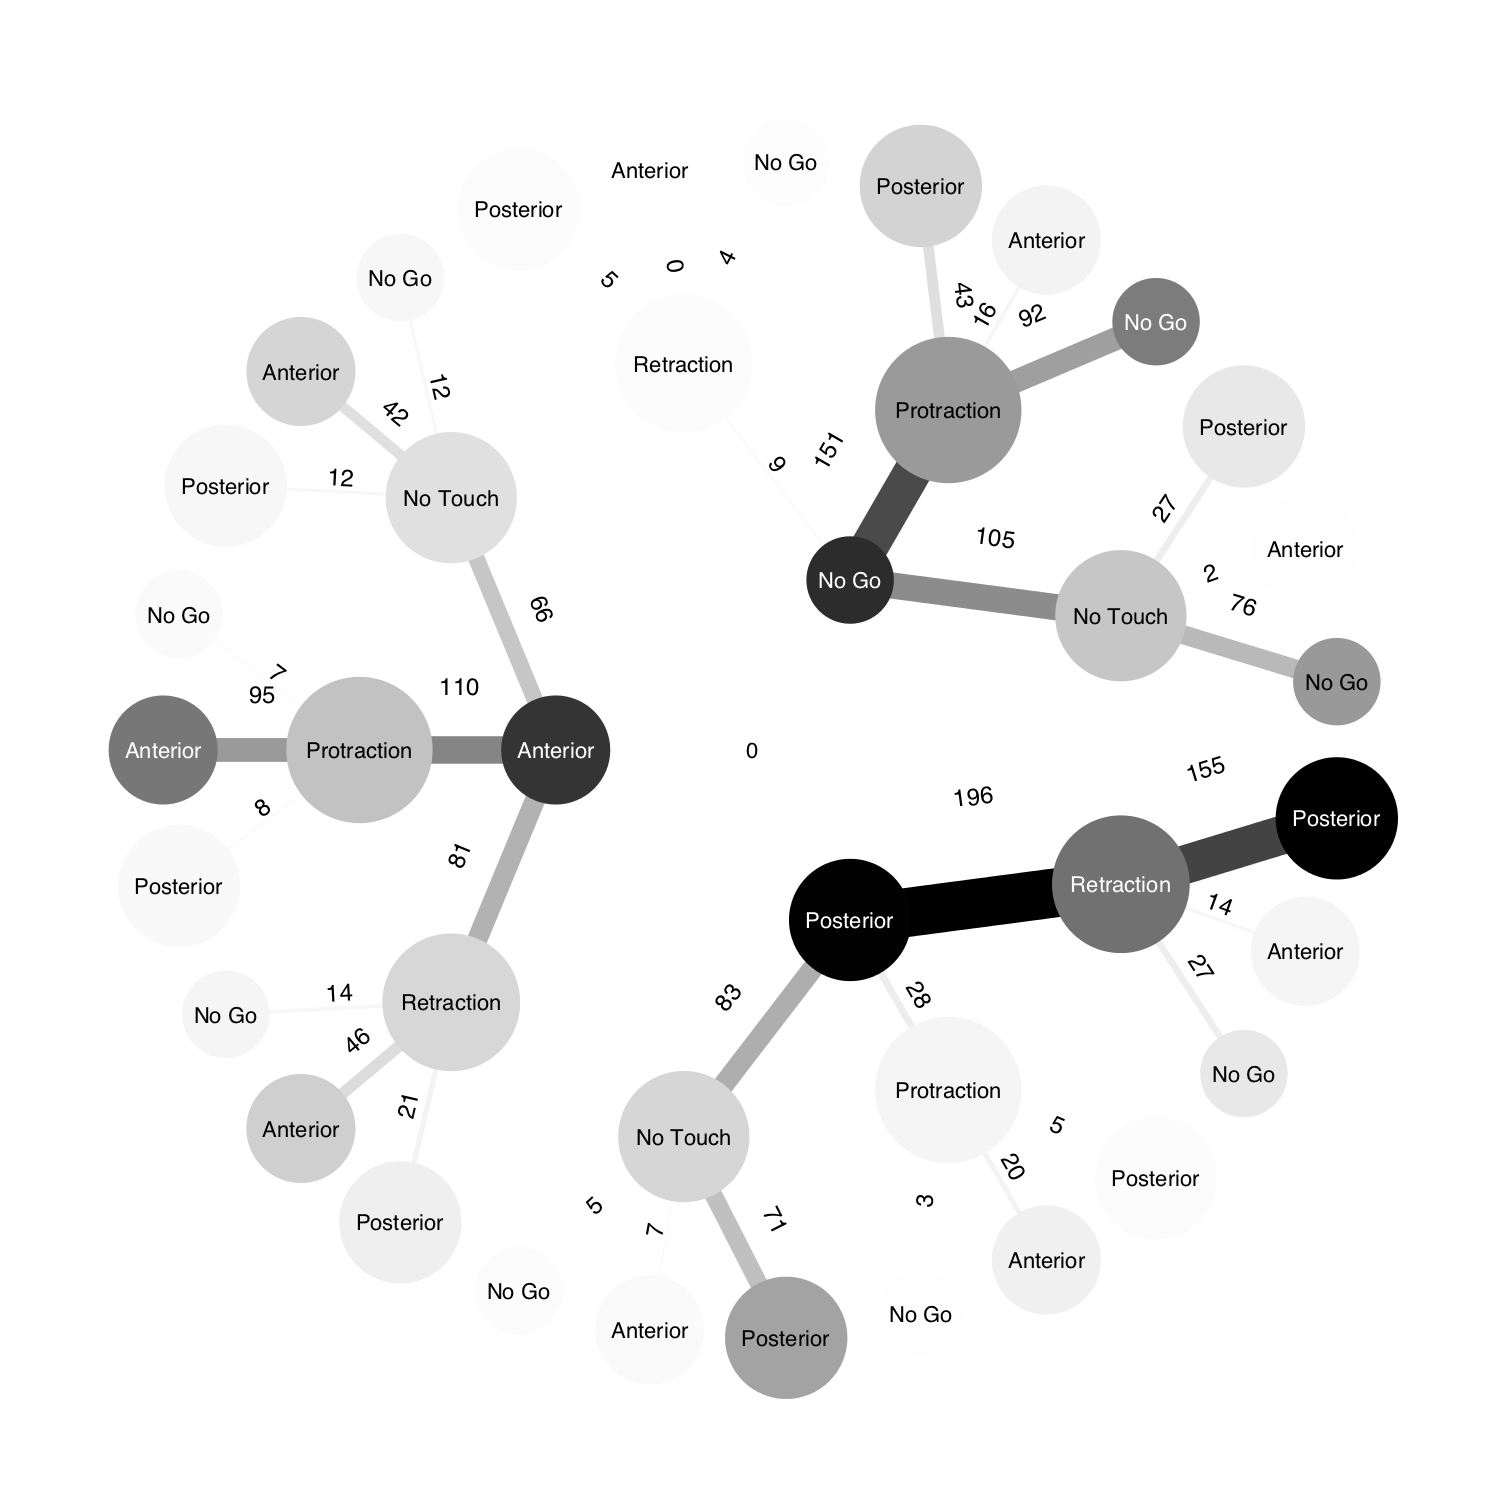

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x115f86080, at 0x1274a6208>

In [18]:
# Try graph of trialtype/choice/touchtype plots
# P_ijk_ON

# import graph_tool.all as gt

cm_3 = np.zeros([3,3,3])
for i in range(len(tt) - 2):
    
    cm_3[tt[i]-1,proret[i]-1 ,ch[i]-1] += 1

# Make graph
cm_G = gt.Graph(directed = False)

# trialtypes = ['P','A','NG']
# touchtypes = ['Ret','Pro','NT']
# choices = ['P','A','NG']
trialtypes = ['Posterior','Anterior','No Go']
touchtypes = ['Retraction','Protraction','No Touch']
choices = ['Posterior','Anterior','No Go']

edge_weights_cm_G = cm_G.new_edge_property('double')
edge_labels_cm_G = cm_G.new_edge_property('string')
node_labels_cm_G = cm_G.new_vertex_property('string')
node_size_cm_G = cm_G.new_vertex_property('double')
h = cm_G.add_vertex()
node_labels_cm_G[h] = "0"

for i in range(cm_3.shape[0]):
    v = cm_G.add_vertex()
    node_labels_cm_G[v] = trialtypes[i]
    e = cm_G.add_edge(h,v)
    node_size_cm_G[v] = np.sum(cm_3[i]) / 4
  
    for j in range(cm_3.shape[1]):
        v2 = cm_G.add_vertex()
        node_labels_cm_G[v2] = touchtypes[j]
        e = cm_G.add_edge(v,v2)
    
        edge_weights_cm_G[e] = np.sum(cm_3[i,j]) /4
        edge_labels_cm_G[e] = str(int(np.sum(cm_3[i,j])))
        node_size_cm_G[v2] = np.sum(cm_3[i,j]) /4
    
        for k in range(cm_3.shape[2]):
            v3 = cm_G.add_vertex()
            node_labels_cm_G[v3] = choices[k]
            e2 = cm_G.add_edge(v2,v3)
      
            edge_weights_cm_G[e2] = int(cm_3[i,j,k])/4
            edge_labels_cm_G[e2] = str(int(cm_3[i,j,k]))
            node_size_cm_G[v3] = int(cm_3[i,j,k])/2

# Plot graph
pos = gt.radial_tree_layout(cm_G,cm_G.vertex(0))
# cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black
cmap =plt.get_cmap('Greys')
gt.graph_draw(cm_G,pos=pos,vertex_size=node_size_cm_G,edge_pen_width=edge_weights_cm_G,
              vertex_text = node_labels_cm_G, #vertex_text_position = 'centered',
              edge_text=edge_labels_cm_G,
              vertex_font_size = 22, vertex_font_family = 'sansserif',
              edge_font_size = 24, edge_font_family = 'sansserif',
              ecmap=cmap, vcmap=cmap, 
              edge_color = edge_weights_cm_G,
              vertex_color = node_size_cm_G,
              vertex_fill_color = node_size_cm_G,
              output_size=(1500, 1500), fit_view=0.8,
#               output="../figs/classification/pro_ret/310816/tt_touch_ch_graph_BW_"+ mouse_name +".pdf")
              
              output="../figs/classification/pro_ret/36/tt_touch_ch_graph_BW_"+ mouse_name +".pdf")



In [137]:
np.sum(cm_3)

913.0

In [73]:
error_matrix

array([[  25.,  236.,   80.],
       [  62.,   15.,  189.],
       [ 148.,  158.,    2.]])

In [74]:
choice_matrix

array([[  25.,  241.,   86.],
       [  77.,   54.,  164.],
       [ 133.,  114.,   21.]])

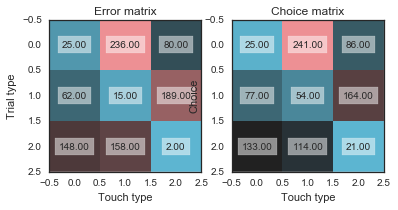

In [81]:
with sns.axes_style("white"):
    cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(error_matrix,interpolation='none',cmap=cmap)
    for i in range(0,3):
        for j in range(0,3):
            ax[0].text(j, i, "{0:.2f}".format(error_matrix[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

        
    ax[0].set_title('Error matrix') # + '. ' + str(int(100 * accuracy_score(tt,c_tt))) + '%')
    ax[0].set_ylabel('Trial type')
    ax[0].set_xlabel('Touch type')
    ax[1].imshow(choice_matrix,interpolation='none',cmap=cmap)
    for i in range(0,3):
        for j in range(0,3):
            ax[1].text(j, i, "{0:.2f}".format(choice_matrix[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

    ax[1].set_title('Choice matrix') # + '. ' + str(int(100 * accuracy_score(tt,ch))) + '%')
    ax[1].set_ylabel('Choice')
    ax[1].set_xlabel('Touch type')
# plt.savefig('figs/graphs/pro_ret_confmatrix_TT_32_full.png')

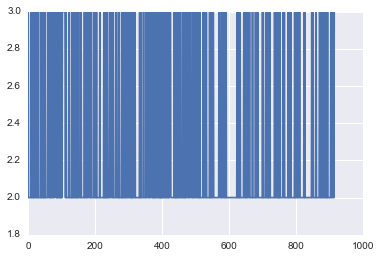

In [24]:
plt.plot(c_ch)

In [26]:
print(confusion_matrix(ch,proret))
print(confusion_matrix(tt,proret))


[[164  54  77]
 [ 86 241  25]
 [ 21 114 133]]
[[189  15  62]
 [ 80 236  25]
 [  2 158 148]]
